## Ntropy AI demo - Multimodal RAG on S&P 500 performance report charts
for this demo, we've taken charts images from the pdf https://www.spglobal.com/spdji/en/documents/performance-reports/dashboard-sp-500-factor.pdf

make sure you have [Ollama](https://ollama.com) setup locally

first, download the required libraries

In [ ]:
!pip install ntropy-ai ntropy-ai[providers-openai] ntropy-ai[providers-ollama] ntropy-ai[providers-aws]

we will now import the required libraries

In [10]:
from ntropy.core.auth import BaseAuth # for Ntropy Central Auth System
import os
from ntropy.core.utils import clear_cache # a function to clear the cached files for the embeddings
from ntropy.core.utils.base_format import Document # the Document class to store the data
from ntropy.core.providers.aws import utils as aws_utils # a utility function to upload the images to S3

# hide warning
import warnings
warnings.filterwarnings('ignore')


In [2]:
db_instance = BaseAuth() # we first import the BaseAuth class, which is the class for the Ntropy Central Auth System
key_file = os.path.join(os.getcwd(), "private_key.pem") # we get the path to the private key file, which is the 'password' to sign in
db_instance.connect(key_file=key_file) # we connect to the database
#if everything goes well, you should see a message like this:

AWS connection initialized successfully.
Pinecone connection initialized successfully.
OpenAI connection initialized successfully.


>  **Note:** if you need to add API keys / secrets, please check the notebook LINK

we can now list the models available on Ntropy with the following function:

In [3]:
from ntropy.core.providers import list_models
list_models()

{'AWS': {'embeddings_models': ['amazon.titan-embed-image-v1',
   'amazon.titan-embed-text-v2:0']},
 'OpenAI': {'embeddings_models': ['openai.clip-vit-base-patch32'],
  'models': ['gpt-4o']},
 'Ollama': {'models': ['llava-phi3:latest', 'llava:13b']}}

in the folder sp-500-images, we have 11 images extracted from the S&P 500 performance report. We are now going to create embeddings using the OpenAI CLIP-ViT-Base-Patch32 model, which is an opensource multimodal embeddings model. But before this, we have to convert our images to Document class, because the Document class is the class used by Ntropy to unify the data format. We are also going to upload the images on a aws s3 bucket, because OpenAI GPT 4o (one of the multimodal LLM we're going to use), only accept images urls (that are stored in the cloud).

In [4]:
from tqdm import tqdm # use tqdm to have a pretty loading bar

images_ = [] # initialize empty images_ list
for file in tqdm(os.listdir('sp-500-images'), desc="Uploading images"): # iterate through each file
    # we're going to use the aws_utils helper function to upload the images to the s3 bucket
    # the function directly upload the image to the s3 bucket and return the url. Please check the notebook LINK for more configuration details
    img_url = aws_utils.upload_to_s3(os.path.join('sp-500-images', file))
    images_.append(Document(image=img_url, metadata={'type': 'image'})) # we now create a Document type object for each image, and append it to the images_ list

Uploading images: 100%|██████████| 11/11 [00:08<00:00,  1.28it/s]


here's an overview of the images_ list that contains the Document object, note that metadata={'type': 'image'} and image=img_url (or local path) are very important. For more details, please check the FORMAT section of the notebook LINK

In [5]:
images_

[Document(id='dd12347b72f24cc3b9bca46f5e77cd5e', metadata={'type': 'image'}, page_number=None, content=None, image='https://ntropy-test.s3.amazonaws.com/sp-500-images/8.png'),
 Document(id='6831a594a04248d1a79a6fedfe55ff9f', metadata={'type': 'image'}, page_number=None, content=None, image='https://ntropy-test.s3.amazonaws.com/sp-500-images/9.png'),
 Document(id='4950d71d5a1f49babe9fb43d680dec62', metadata={'type': 'image'}, page_number=None, content=None, image='https://ntropy-test.s3.amazonaws.com/sp-500-images/11.png'),
 Document(id='c26958ac34d04f9d81d897f0d70e14f0', metadata={'type': 'image'}, page_number=None, content=None, image='https://ntropy-test.s3.amazonaws.com/sp-500-images/10.png'),
 Document(id='f7c48b91b79b4725b7ed2772836c793b', metadata={'type': 'image'}, page_number=None, content=None, image='https://ntropy-test.s3.amazonaws.com/sp-500-images/4.png'),
 Document(id='3853d623930e41e5a62b3764b1440742', metadata={'type': 'image'}, page_number=None, content=None, image='ht

In [6]:
from tqdm import tqdm
from ntropy.core.providers import openai # we import the openai class from the providers. a complete guide is available in the notebook LINK

embeddings = []
for doc in tqdm(images_, desc="Embedding documents"):
    # we now create the embeddings for each image, and append them to the embeddings list
    # the openai.OpenAIEmbeddings directly return us a Vector object, that contains the embedding and the original document
    embeddings.append(openai.OpenAIEmbeddings(model='openai.clip-vit-base-patch32', document=doc)) 

Embedding documents: 100%|██████████| 11/11 [00:07<00:00,  1.50it/s]


we will now initialize a Pinecone vector store.

first, we create a Pinecone object, and then we create the index (make sure the dimension is the same as the embeddings model), set the default index, set the default embeddings model (make sure it is the same as the one we used to create the embeddings), and finally we describe the index.

In [7]:
from ntropy.core.vector_store.pinecone import Pinecone

pc = Pinecone() # initialize a Pinecone object
# create the index, dimension should be the same as the embeddings model. 
# metric can be chosen from the pinecone documentation
pc.create_index(index_name="sp500-img", dimension=512, metric="cosine") 
pc.set_index(index_name="sp500-img") # set the default index

In [8]:
pc.set_embeddings_model(model="openai.clip-vit-base-patch32", model_settings={}) # we set the default embedding model, which should be the same as the one we used to create the embeddings
# we can set a model settings but it is not required

In [9]:
pc.client.describe_index("sp500-img")

{'dimension': 512,
 'host': 'sp500-img-dzykh3w.svc.aped-4627-b74a.pinecone.io',
 'metric': 'cosine',
 'name': 'sp500-img',
 'spec': {'serverless': {'cloud': 'aws', 'region': 'us-east-1'}},
 'status': {'ready': True, 'state': 'Ready'}}

In [10]:

from tqdm import tqdm
for v in tqdm(embeddings, desc="Adding vectors"):
    pc.add_vectors(vectors=[v]) #we add the vector individually on the pinecone vector store

Adding vectors: 100%|██████████| 11/11 [00:05<00:00,  1.97it/s]


In [11]:
pc.query(query_text="how much is the S&P 500 momentum percentage for June ?") # we can now query the pinecone vector store, note that it returns a list of Vector object with image url and the original document

[Vector(id='5374d25f588a42e39c35fd8bce0d0dfd', document_id='c26958ac34d04f9d81d897f0d70e14f0', score=0.300759792, vector=[0.146972656, 0.278808594, -0.525390625, 0.150878906, -0.178466797, -0.264404297, 0.0653686523, 0.651855469, 0.233642578, -0.151733398, -0.0942993164, -0.240356445, -0.964355469, -0.210693359, -0.247436523, -0.250732422, -0.131469727, -0.16015625, -0.321777344, 0.444335938, -0.0129928589, 0.0615539551, -0.0331726074, 0.0658569336, -0.00235366821, 0.0162200928, -0.298339844, 0.384521484, -0.0577392578, 0.0631713867, 0.285888672, 0.649414062, -0.272949219, -0.12878418, 0.208984375, 0.113220215, 0.0912475586, 0.191650391, 0.290527344, 0.11920166, -0.430419922, 0.101501465, 0.0368042, -0.370605469, -0.259033203, 0.811523438, -0.0379943848, 0.0853271484, 0.0469360352, -0.391113281, -0.0651855469, -0.415771484, -0.223144531, -0.146362305, 0.0735473633, -0.342773438, -0.144287109, 0.354736328, -0.317138672, -0.296386719, -0.526855469, 0.0668334961, -0.297851562, -0.68310546

here, we are going to setup the vector store for retrieval

we have to set a default embeddings model,which should be the same as the one we used to create the embeddings

we can now set the retriever settings, which is the settings for the retrieval process.
- top_k is the number of documents to return
- include_values is a boolean that indicates if we want to include the values in the response (from pinecone, but we dont really need this)

In [3]:
from ntropy.core.vector_store.pinecone import Pinecone

pc = Pinecone()
pc.set_index(index_name="sp500-img") # set vector store to the index we created before
pc.set_embeddings_model(model="openai.clip-vit-base-patch32", model_settings={}) # set the default embedding model, which should be the same as the one we used to create the embeddings
pc.set_retriever_settings(top_k=1, include_values=False) # we only want one results, too many image results can affect the quality of the response, especially with small models

In [14]:
from ntropy.core.providers import openai # we import the openai class from the providers. a complete guide is available in the notebook LINK
from ntropy.core.utils.prompt import RagPrompt 
# we import the RagPrompt class from the utils.prompt module, which is just a prompt that is gonna be used for RAG
# you can modify it at any time

model = openai.OpenaiModel(
    model_name="gpt-4o", # gpt 4o on top
    retriever=pc.query, # we just need to set the retriever to the retrieve function
    agent_prompt=RagPrompt # we set the agent prompt to the RagPrompt class
    # you can also set a system prompt if you want, full guide is available in the notebook LINK
)


In [15]:
r = model.chat(query="how much is the June Total Return for S&P 500 Growth?") # let's give it a try
r

'The June Total Return for S&P 500 Growth is 7.0%.'

In [16]:
model.history.get_history() # we can now check the message history, and see the returned documents

[{'role': 'user',
  'content': 'Using this data:  and the images. Respond to this prompt: how much is the June Total Return for S&P 500 Growth?',
  'images': ['https://ntropy-test.s3.amazonaws.com/sp-500-images/1.png'],
  'timestamp': '2024-07-15 16:10:20.419'},
 {'role': 'assistant',
  'content': 'The June Total Return for S&P 500 Growth is 7.0%.',
  'images': None,
  'timestamp': '2024-07-15 16:10:23.788'}]

a preview of the returned image

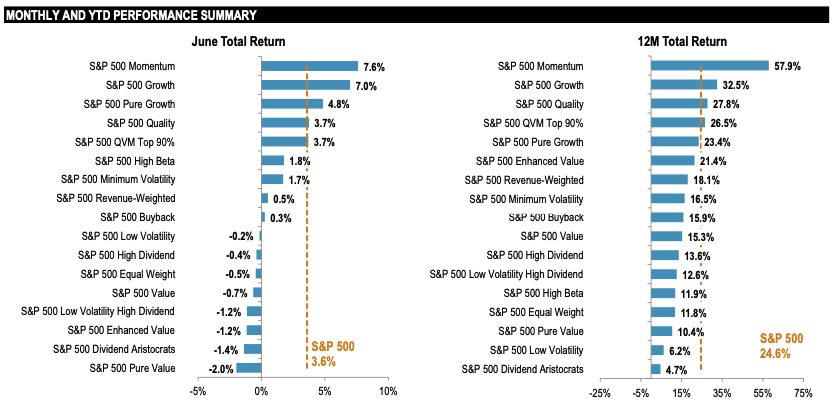

In [18]:
from PIL import Image
import requests
from io import BytesIO
import IPython.display as display

history = model.history.get_history()
for message in history:
    if message['images']:
        for image_url in message['images']:
            response = requests.get(image_url)
            img = Image.open(BytesIO(response.content))
            display.display(img)
 # and we can see that the S&P 500 growth percentage for June is indeed 7.0% !

now, we can try with Ollama. Note that the result is not great because it is a local quantized model, and the image is pretty complex.

the method is the same as OpenAI models, eveything is uniformed and we support ALL MLLM from Ollama

In [4]:
from ntropy.core.providers import ollama
from ntropy.core.utils.prompt import RagPrompt

model = ollama.OllamaModel(
    model_name="llava:13b",
    retriever=pc.query,
    agent_prompt=RagPrompt
)
# the schat method is streaming chat, you can also use sgenerate, generate or chat.
# Ollama generate method is for chat completion, and chat support history 
stream = model.schat(query="how much is the June Total Return for S&P 500 Growth?") 
for chunk in stream:
    print(chunk, flush=True, end='')

 The June Total Return for S&P 500 Growth is 7.9%.

In [11]:
clear_cache() # we have some saved files locally, because our images are stored online, gpt4o needs the images as urls and Ollama needs the images as local path

cache cleared !
